In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --------------------------
# Tic Tac Toe Environment
# --------------------------

class TicTacToe:
    def __init__(self):
        self.board = np.zeros(9, dtype=int) # 0: empty, 1: X, -1: O
        self.winner = None
        self.game_over = False
        
    def reset(self):
        self.board = np.zeros(9, dtype=int)
        self.winner = None
        self.game_over = False
        return self.get_state()
    
    def get_state(self):
        # Return tuple as state identifier
        return tuple(self.board)
    
    def available_actions(self):
        return np.where(self.board == 0)[0]
    
    def step(self, action, player):
        if self.board[action] != 0:
            raise ValueError("Invalid move")
        
        self.board[action] = player
        
        # Check winner
        # Rows
        for i in range(0, 9, 3):
            if abs(sum(self.board[i:i+3])) == 3:
                self.winner = player
                self.game_over = True
                return self.get_state(), self.get_reward(player), True
        
        # Cols
        for i in range(3):
            if abs(sum(self.board[i::3])) == 3:
                self.winner = player
                self.game_over = True
                return self.get_state(), self.get_reward(player), True
                
        # Diagonals
        if abs(sum(self.board[[0, 4, 8]])) == 3 or abs(sum(self.board[[2, 4, 6]])) == 3:
            self.winner = player
            self.game_over = True
            return self.get_state(), self.get_reward(player), True
            
        if len(self.available_actions()) == 0:
            self.game_over = True
            return self.get_state(), 0, True # Draw
            
        return self.get_state(), 0, False

    def get_reward(self, player):
        if self.winner == player:
            return 1
        elif self.winner == -player: # Opponent won
            return -1 # Should technically not happen in the return of step() for the mover
        elif self.winner is None:
            return 0
        return 0

# --------------------------
# Minimax for Optimal Actions
# --------------------------
# Pre-computing optimal moves for all states to make checking fast

memo_opt = {}

def get_canonical_state(board_tuple):
    return board_tuple

def minimax(board, player, is_maximizing):
    state = tuple(board)
    
    # Check terminal
    # Use a lightweight check here or rely on recursion depth for small game
    # ... Simplified for brevity, doing full check
    
    # Check win
    for i in range(0, 9, 3):
        if abs(sum(board[i:i+3])) == 3: return (1 if board[i] == player else -1) * (10)
    for i in range(3):
        if abs(sum(board[i::3])) == 3: return (1 if board[i] == player else -1) * (10)
    if abs(sum(board[[0, 4, 8]])) == 3: return (1 if board[0] == player else -1) * (10)
    if abs(sum(board[[2, 4, 6]])) == 3: return (1 if board[2] == player else -1) * (10)
    
    avail = [i for i, x in enumerate(board) if x == 0]
    if not avail: return 0

    if is_maximizing:
        best_score = -float('inf')
        for a in avail:
            board[a] = player
            score = minimax(board, player, False)
            board[a] = 0
            best_score = max(score, best_score)
        return best_score
    else:
        best_score = float('inf')
        opponent = -player
        for a in avail:
            board[a] = opponent
            score = minimax(board, player, True)
            board[a] = 0
            best_score = min(score, best_score)
        return best_score

def get_optimal_actions(board_tuple, player):
    if board_tuple in memo_opt:
        return memo_opt[board_tuple]
    
    board = np.array(board_tuple)
    avail = [i for i, x in enumerate(board) if x == 0]
    
    # Calculate values for all actions
    action_values = []
    
    # We want to maximize the outcome for 'player'
    # So we call minimax as maximizer
    for a in avail:
        board[a] = player
        # After we move, it's opponent's turn (minimizer)
        val = minimax(board, player, False) # Value for us
        board[a] = 0
        action_values.append((a, val))
        
    if not action_values:
        return []
        
    max_val = max(v for k, v in action_values)
    best_actions = [k for k, v in action_values if v == max_val]
    
    memo_opt[board_tuple] = best_actions
    return best_actions

# --------------------------
# RL Agent (Q-Learning)
# --------------------------

class Agent:
    def __init__(self, epsilon=0.1, alpha=0.5, gamma=1.0):
        self.q_table = {} # state -> [values for 9 actions] (store broadly)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.prev_state = None
        self.prev_action = None
        
    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        return self.q_table[state]
    
    def choose_action(self, state, available_actions):
        if np.random.random() < self.epsilon:
            return np.random.choice(available_actions)
        else:
            q_values = self.get_q(state)
            # Filter for available
            mask_q = np.full(9, -np.inf)
            mask_q[available_actions] = q_values[available_actions]
            
            # Argmax with random tie-breaking
            max_val = np.max(mask_q)
            best_actions = np.where(mask_q == max_val)[0]
            return np.random.choice(best_actions)

    def learn(self, current_state, reward, done, available_actions):
        if self.prev_state is None:
            return

        q_values_next = self.get_q(current_state)
        max_q_next = 0 if done else np.max(q_values_next[available_actions]) if len(available_actions) > 0 else 0
        
        old_val = self.q_table[self.prev_state][self.prev_action]
        self.q_table[self.prev_state][self.prev_action] = old_val + self.alpha * (reward + self.gamma * max_q_next - old_val)



In [2]:
# --------------------------
# Precompute Optimal Moves
# --------------------------

optimal_moves_cache = {}

def precompute_optimal_moves():
    # BFS/DFS to find all reachable states and compute optimal moves for them
    # For both X (1) and O (-1) turn logic
    
    # State is tuple of 9 ints.
    # Player turn can be inferred from sum(board). 
    # sum=0 -> X's turn. sum=1 -> O's turn. sum=0 again? No.
    # X always starts. 
    # State tuple doesn't encode who starts if we play random X/O roles?
    # Actually, in our env, if I am O, there is an X somewhere.
    # We can infer player turn: sum(board) == 0 -> X (1) to move. sum(board) == 1 -> O (-1) to move.
    
    # But wait, the environment allows assigning any player.
    # We will assume Standard Tic-Tac-Toe: X always goes first.
    # If "Agent is O", the random opponent played X first.
    # So the state sum tells us whose turn it is.
    
    queue = [tuple(np.zeros(9, dtype=int))]
    seen = set(queue)
    
    print("Precomputing optimal moves...")
    
    # Using a simple iterative process to discover states?
    # Or just lazy load with memoization during the first run? 
    # Lazy load is safer if my manual BFS misses something.
    # But for speed, let's just use the memoized Minimax from earlier, but ensure it caches validly.
    pass

# We'll rely on the caching inside get_optimal_actions to build up speed.
# The previous cell defined 'memo_opt'. We should clear it and use it.
memo_opt = {} 



Starting Experiment: 100 Time-steps
Running for epsilon=0 | Steps: 100 | Games/Step: 2000


Eps 0: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]


Running for epsilon=0.1 | Steps: 100 | Games/Step: 2000


Eps 0.1: 100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


Running for epsilon=0.01 | Steps: 100 | Games/Step: 2000


Eps 0.01: 100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


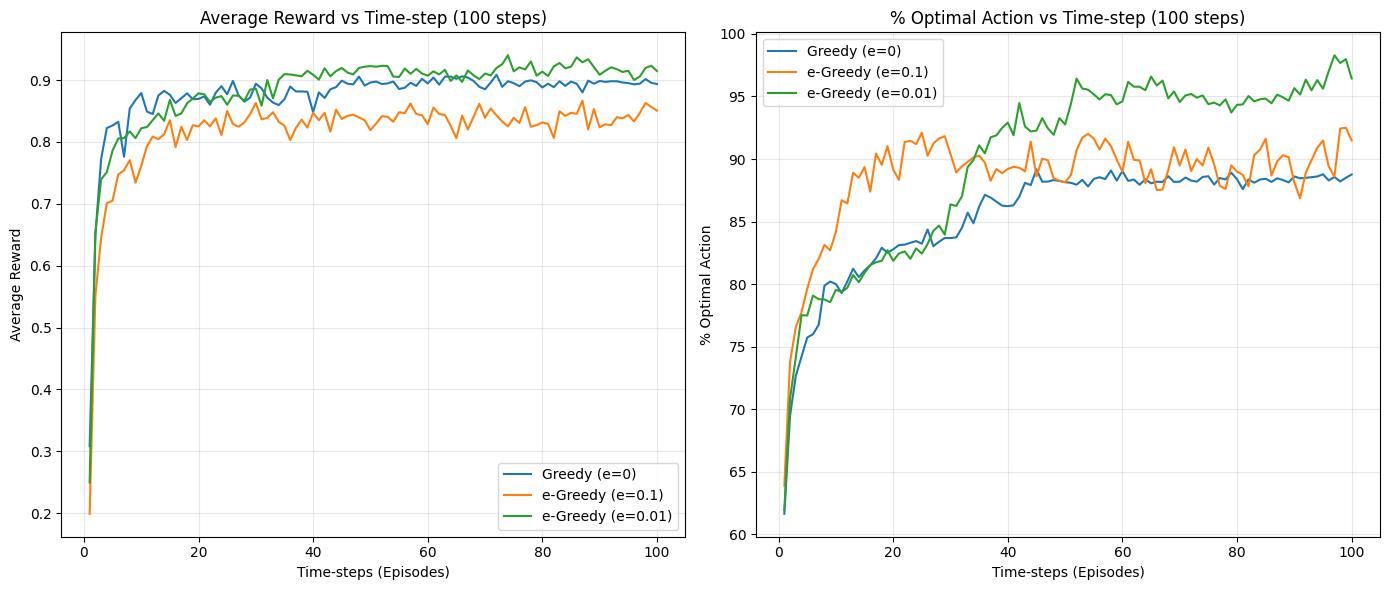


Starting Experiment: 200 Time-steps
Running for epsilon=0 | Steps: 200 | Games/Step: 2000


Eps 0: 100%|██████████| 200/200 [00:55<00:00,  3.60it/s]


Running for epsilon=0.1 | Steps: 200 | Games/Step: 2000


Eps 0.1: 100%|██████████| 200/200 [00:54<00:00,  3.70it/s]


Running for epsilon=0.01 | Steps: 200 | Games/Step: 2000


Eps 0.01: 100%|██████████| 200/200 [00:52<00:00,  3.84it/s]


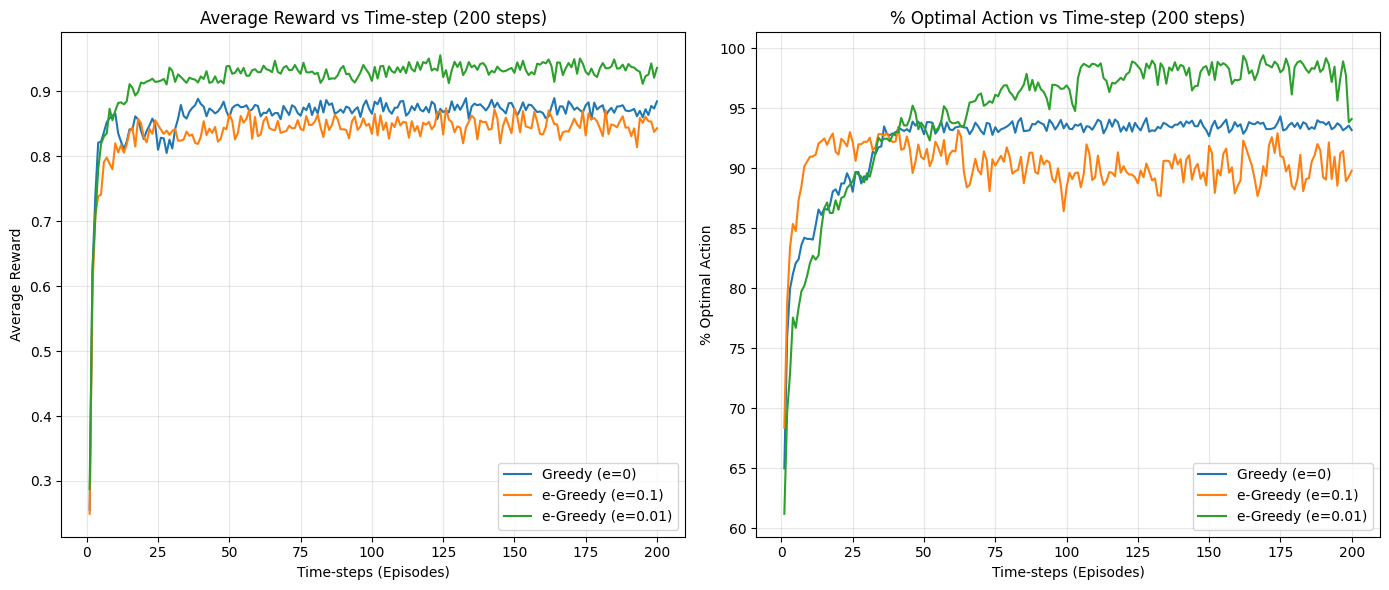


Starting Experiment: 400 Time-steps
Running for epsilon=0 | Steps: 400 | Games/Step: 2000


Eps 0: 100%|██████████| 400/400 [01:55<00:00,  3.46it/s]


Running for epsilon=0.1 | Steps: 400 | Games/Step: 2000


Eps 0.1: 100%|██████████| 400/400 [01:48<00:00,  3.67it/s]


Running for epsilon=0.01 | Steps: 400 | Games/Step: 2000


Eps 0.01: 100%|██████████| 400/400 [01:45<00:00,  3.80it/s]


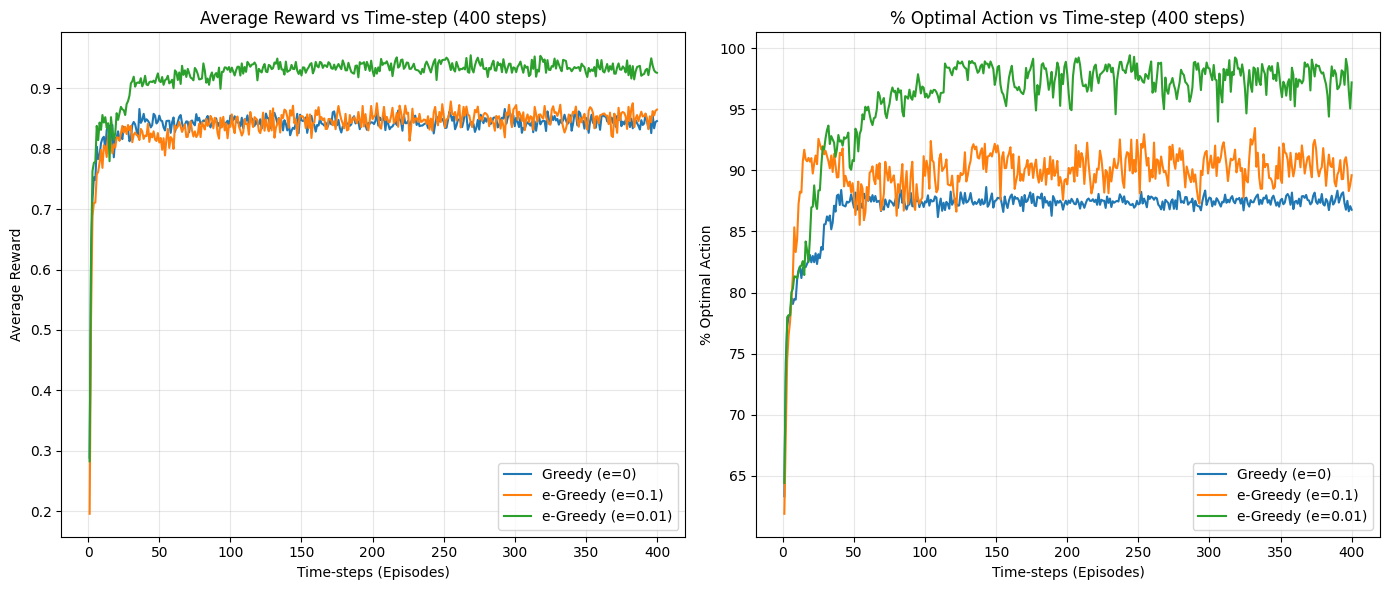

In [3]:
# --------------------------
# Corrected Agent & Simulation
# --------------------------

class QLearningAgent:
    def __init__(self, epsilon=0.1, alpha=0.5, gamma=1.0):
        self.q_table = {} 
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        return self.q_table[state]
    
    def choose_action(self, state, available_actions):
        if np.random.random() < self.epsilon:
            return np.random.choice(available_actions)
        else:
            q_values = self.get_q(state)
            mask_q = np.full(9, -np.inf)
            mask_q[available_actions] = q_values[available_actions]
            max_val = np.max(mask_q)
            # Break ties randomly
            best_actions = np.where(mask_q == max_val)[0]
            return np.random.choice(best_actions)

    def learn(self, state, action, reward, next_state, done, available_actions_next):
        q_values = self.get_q(state)
        old_val = q_values[action]
        
        if done:
            target = reward
        else:
            q_values_next = self.get_q(next_state)
            if len(available_actions_next) == 0:
                target = reward
            else:
                max_q_next = np.max(q_values_next[available_actions_next])
                target = reward + self.gamma * max_q_next
        
        self.q_table[state][action] = old_val + self.alpha * (target - old_val)

def plot_results(results_rewards, results_optimal, n_timesteps):
    x = np.arange(1, n_timesteps + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Plot Average Reward
    plt.subplot(1, 2, 1)
    for eps, data in results_rewards.items():
        label = f'Greedy (e=0)' if eps == 0 else f'e-Greedy (e={eps})'
        plt.plot(x, data, label=label)
    plt.xlabel('Time-steps (Episodes)')
    plt.ylabel('Average Reward')
    plt.title(f'Average Reward vs Time-step ({n_timesteps} steps)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot % Optimal Action
    plt.subplot(1, 2, 2)
    for eps, data in results_optimal.items():
        label = f'Greedy (e=0)' if eps == 0 else f'e-Greedy (e={eps})'
        plt.plot(x, data, label=label)
    plt.xlabel('Time-steps (Episodes)')
    plt.ylabel('% Optimal Action')
    # plt.ylim(0, 100)
    plt.title(f'% Optimal Action vs Time-step ({n_timesteps} steps)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def run_experiment(n_timesteps, n_games_per_step, epsilons):
    results_rewards = {}
    results_optimal = {}

    for eps in epsilons:
        print(f"Running for epsilon={eps} | Steps: {n_timesteps} | Games/Step: {n_games_per_step}")
        
        # Single agent persists across all time-steps for this epsilon
        agent = QLearningAgent(epsilon=eps, alpha=0.5, gamma=1.0)
        
        avg_rewards_per_step = np.zeros(n_timesteps)
        avg_optimal_per_step = np.zeros(n_timesteps)
        
        # Outer loop: Time-steps
        for t in tqdm(range(n_timesteps), desc=f"Eps {eps}"):
            
            step_total_reward = 0
            step_optimal_moves = 0
            step_total_moves = 0
            
            # Inner loop: Runs (Games per time-step)
            for g in range(n_games_per_step):
                env = TicTacToe()
                state = env.reset()
                done = False
                
                # Determine Agent Role: X (1) or O (-1)
                agent_player = 1 if np.random.random() < 0.5 else -1
                
                # If Agent is O, Opponent (X) moves first
                if agent_player == -1:
                    avail = env.available_actions()
                    opp_action = np.random.choice(avail)
                    state, _, done = env.step(opp_action, -agent_player)
                
                game_reward = 0
                
                while not done:
                    avail = env.available_actions()
                    action = agent.choose_action(state, avail)
                    
                    # Check Optimality
                    opt_moves = get_optimal_actions(state, agent_player)
                    if action in opt_moves:
                        step_optimal_moves += 1
                    step_total_moves += 1
                    
                    next_state, reward, done = env.step(action, agent_player)
                    
                    if not done:
                        opp_avail = env.available_actions()
                        opp_action = np.random.choice(opp_avail)
                        next_state, opp_reward, done = env.step(opp_action, -agent_player)
                        
                        if done:
                            if opp_reward == 1: # Opponent won
                                reward = -1
                            else:
                                reward = 0
                    
                    next_avail = env.available_actions() if not done else []
                    agent.learn(state, action, reward, next_state, done, next_avail)
                    
                    state = next_state
                    if done:
                        game_reward = reward
                
                step_total_reward += game_reward

            # Average for this time-step
            avg_rewards_per_step[t] = step_total_reward / n_games_per_step
            if step_total_moves > 0:
                avg_optimal_per_step[t] = (step_optimal_moves / step_total_moves) * 100.0
            else:
                avg_optimal_per_step[t] = 0
                    
        results_rewards[eps] = avg_rewards_per_step
        results_optimal[eps] = avg_optimal_per_step
        
    return results_rewards, results_optimal

# --------------------------
# Main Execution Blocks
# --------------------------

# Configuration
# n_runs here is now "Games per Step"
RUNS = 2000 
EPSILONS = [0, 0.1, 0.01]
STEPS_LIST = [100, 200, 400]

for steps in STEPS_LIST:
    print(f"\nStarting Experiment: {steps} Time-steps")
    res_rew, res_opt = run_experiment(steps, RUNS, EPSILONS)
    plot_results(res_rew, res_opt, steps)


Starting Experiment: 100 Time-steps
Running for epsilon=0 | Runs: 2000 | Steps: 100


Eps 0: 100%|██████████| 2000/2000 [00:31<00:00, 64.14it/s]


Running for epsilon=0.1 | Runs: 2000 | Steps: 100


Eps 0.1: 100%|██████████| 2000/2000 [00:32<00:00, 61.03it/s]


Running for epsilon=0.01 | Runs: 2000 | Steps: 100


Eps 0.01: 100%|██████████| 2000/2000 [00:31<00:00, 63.47it/s]


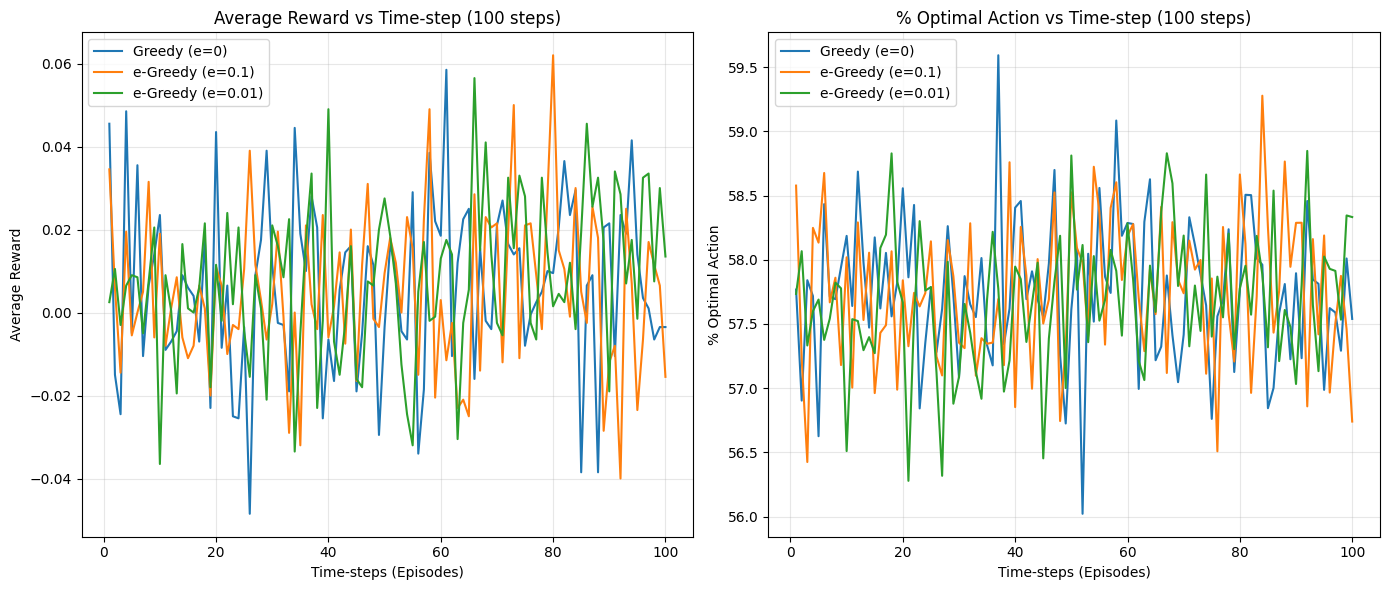


Starting Experiment: 200 Time-steps
Running for epsilon=0 | Runs: 2000 | Steps: 200


Eps 0: 100%|██████████| 2000/2000 [01:02<00:00, 31.76it/s]


Running for epsilon=0.1 | Runs: 2000 | Steps: 200


Eps 0.1: 100%|██████████| 2000/2000 [01:02<00:00, 32.08it/s]


Running for epsilon=0.01 | Runs: 2000 | Steps: 200


Eps 0.01: 100%|██████████| 2000/2000 [01:02<00:00, 31.98it/s]


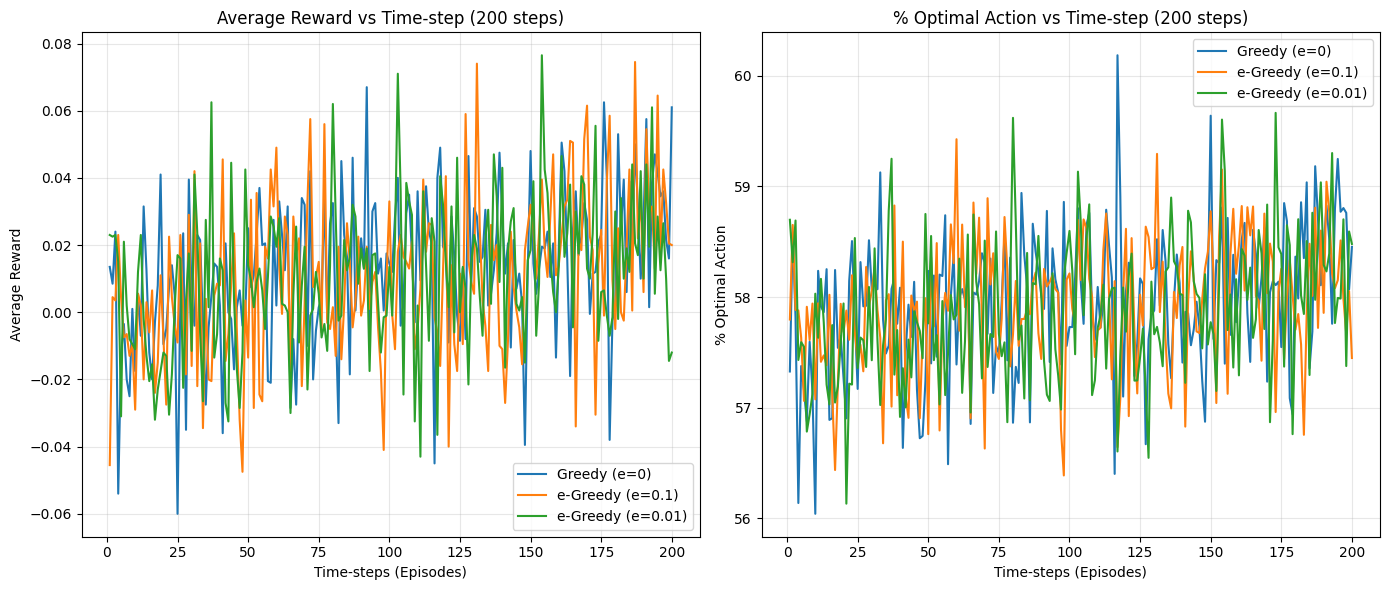


Starting Experiment: 400 Time-steps
Running for epsilon=0 | Runs: 2000 | Steps: 400


Eps 0: 100%|██████████| 2000/2000 [02:05<00:00, 15.98it/s]


Running for epsilon=0.1 | Runs: 2000 | Steps: 400


Eps 0.1: 100%|██████████| 2000/2000 [02:03<00:00, 16.16it/s]


Running for epsilon=0.01 | Runs: 2000 | Steps: 400


Eps 0.01: 100%|██████████| 2000/2000 [02:05<00:00, 15.91it/s]


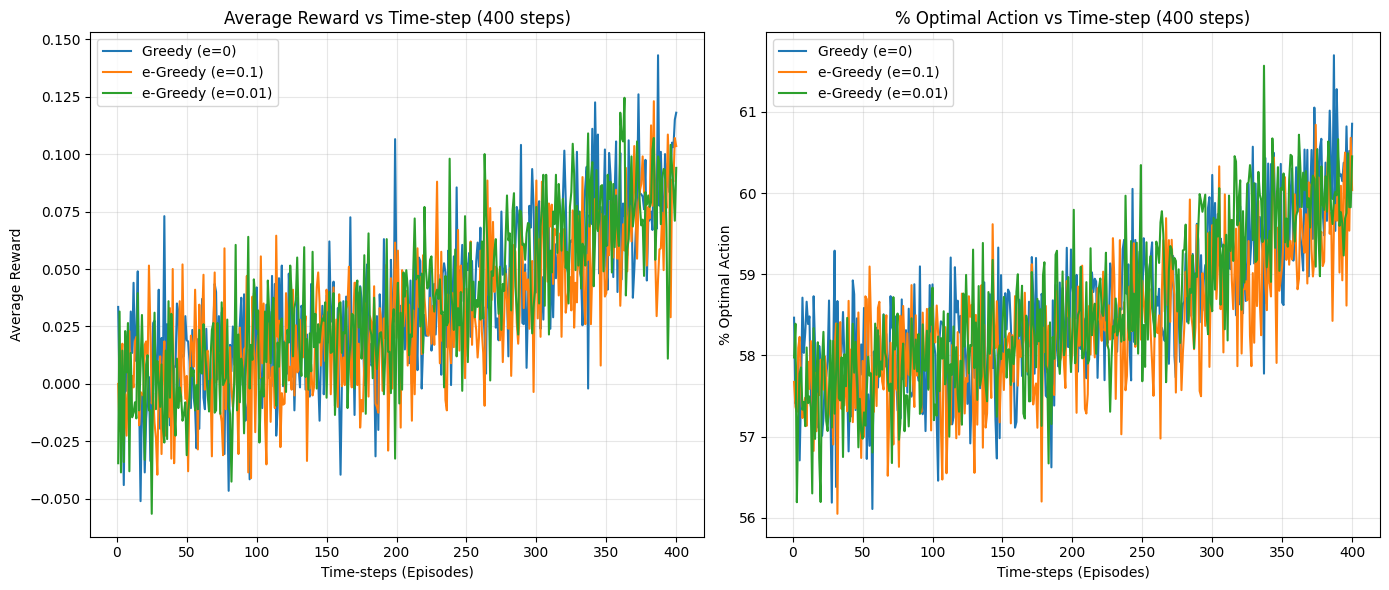

In [4]:
# --------------------------
# Corrected Agent & Simulation
# --------------------------

class QLearningAgent:
    def __init__(self, epsilon=0.1, alpha=0.5, gamma=1.0):
        self.q_table = {} 
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        return self.q_table[state]
    
    def choose_action(self, state, available_actions):
        if np.random.random() < self.epsilon:
            return np.random.choice(available_actions)
        else:
            q_values = self.get_q(state)
            mask_q = np.full(9, -np.inf)
            mask_q[available_actions] = q_values[available_actions]
            max_val = np.max(mask_q)
            # Break ties randomly
            best_actions = np.where(mask_q == max_val)[0]
            return np.random.choice(best_actions)

    def learn(self, state, action, reward, next_state, done, available_actions_next):
        q_values = self.get_q(state)
        old_val = q_values[action]
        
        if done:
            target = reward
        else:
            q_values_next = self.get_q(next_state)
            if len(available_actions_next) == 0:
                target = reward
            else:
                max_q_next = np.max(q_values_next[available_actions_next])
                target = reward + self.gamma * max_q_next
        
        self.q_table[state][action] = old_val + self.alpha * (target - old_val)

def run_experiment(n_timesteps, n_runs, epsilons):
    results_rewards = {}
    results_optimal = {}

    for eps in epsilons:
        print(f"Running for epsilon={eps} | Runs: {n_runs} | Steps: {n_timesteps}")
        
        total_rewards = np.zeros(n_timesteps)
        total_optimal = np.zeros(n_timesteps)
        
        # Using tqdm for progress
        for r in tqdm(range(n_runs), desc=f"Eps {eps}"):
            agent = QLearningAgent(epsilon=eps, alpha=0.5, gamma=1.0)
            
            for t in range(n_timesteps):
                env = TicTacToe()
                state = env.reset()
                done = False
                
                # Determine Agent Role: X (1) or O (-1)
                agent_player = 1 if np.random.random() < 0.5 else -1
                
                # If Agent is O, Opponent (X) moves first
                if agent_player == -1:
                    avail = env.available_actions()
                    opp_action = np.random.choice(avail)
                    state, _, done = env.step(opp_action, -agent_player)
                
                steps_in_game = 0
                optimal_steps = 0
                game_reward = 0
                
                while not done:
                    avail = env.available_actions()
                    action = agent.choose_action(state, avail)
                    
                    # Check Optimality
                    opt_moves = get_optimal_actions(state, agent_player)
                    if action in opt_moves:
                        optimal_steps += 1
                    steps_in_game += 1
                    
                    next_state, reward, done = env.step(action, agent_player)
                    
                    if not done:
                        opp_avail = env.available_actions()
                        opp_action = np.random.choice(opp_avail)
                        next_state, opp_reward, done = env.step(opp_action, -agent_player)
                        
                        if done:
                            if opp_reward == 1: # Opponent won
                                reward = -1
                            else:
                                reward = 0
                    
                    next_avail = env.available_actions() if not done else []
                    agent.learn(state, action, reward, next_state, done, next_avail)
                    
                    state = next_state
                    if done:
                        game_reward = reward
                
                total_rewards[t] += game_reward
                if steps_in_game > 0:
                    total_optimal[t] += (optimal_steps / steps_in_game) * 100.0
                else:
                    total_optimal[t] += 100.0
                    
        results_rewards[eps] = total_rewards / n_runs
        results_optimal[eps] = total_optimal / n_runs
        
    return results_rewards, results_optimal

# --------------------------
# Main Execution Blocks
# --------------------------

# Configuration
# NOTE: 2000 runs is computationally intensive.
RUNS = 2000 
EPSILONS = [0, 0.1, 0.01]
STEPS_LIST = [100, 200, 400]

for steps in STEPS_LIST:
    print(f"\nStarting Experiment: {steps} Time-steps")
    res_rew, res_opt = run_experiment(steps, RUNS, EPSILONS)
    plot_results(res_rew, res_opt, steps)



Starting Experiment: 800 Time-steps
Running for epsilon=0 | Runs: 2000 | Steps: 800


Eps 0: 100%|██████████| 2000/2000 [04:05<00:00,  8.14it/s]


Running for epsilon=0.1 | Runs: 2000 | Steps: 800


Eps 0.1: 100%|██████████| 2000/2000 [04:03<00:00,  8.22it/s]


Running for epsilon=0.01 | Runs: 2000 | Steps: 800


Eps 0.01: 100%|██████████| 2000/2000 [04:03<00:00,  8.23it/s]


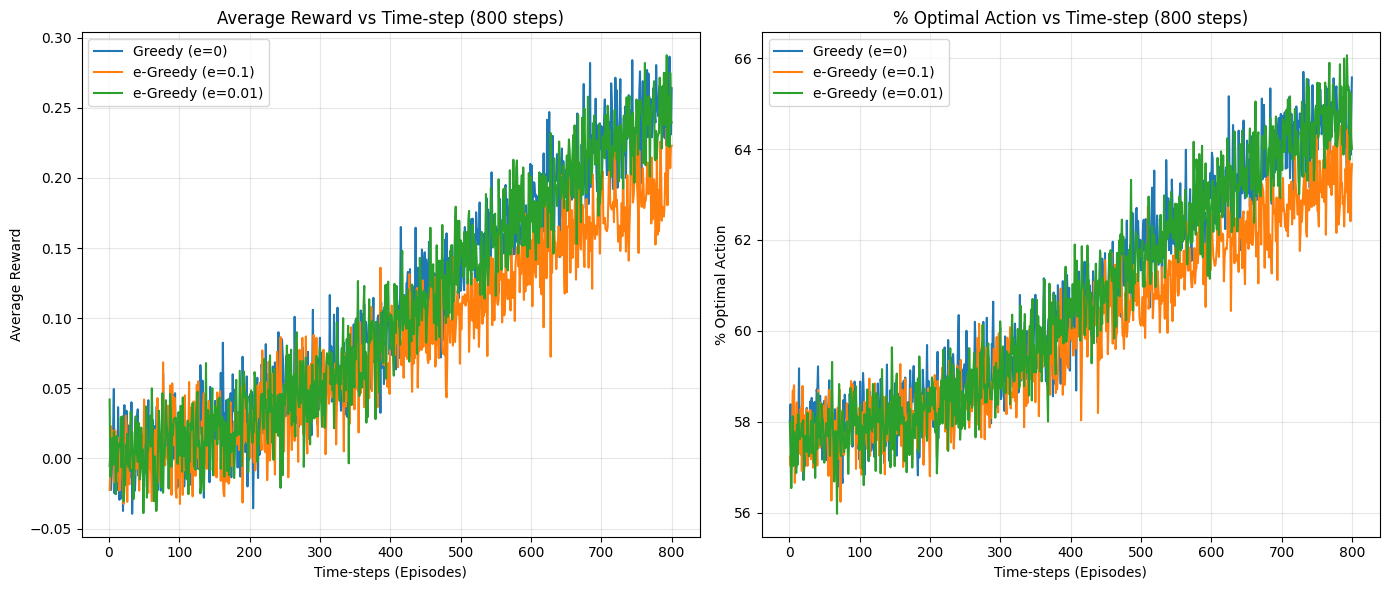

In [5]:
RUNS = 2000 
EPSILONS = [0, 0.1, 0.01]
STEPS_LIST = [800]

for steps in STEPS_LIST:
    print(f"\nStarting Experiment: {steps} Time-steps")
    res_rew, res_opt = run_experiment(steps, RUNS, EPSILONS)
    plot_results(res_rew, res_opt, steps)


Starting Experiment: 2000 Time-steps
Running for epsilon=0 | Runs: 2000 | Steps: 2000


Eps 0: 100%|██████████| 2000/2000 [09:43<00:00,  3.43it/s]


Running for epsilon=0.1 | Runs: 2000 | Steps: 2000


Eps 0.1: 100%|██████████| 2000/2000 [10:09<00:00,  3.28it/s]


Running for epsilon=0.01 | Runs: 2000 | Steps: 2000


Eps 0.01: 100%|██████████| 2000/2000 [09:31<00:00,  3.50it/s]


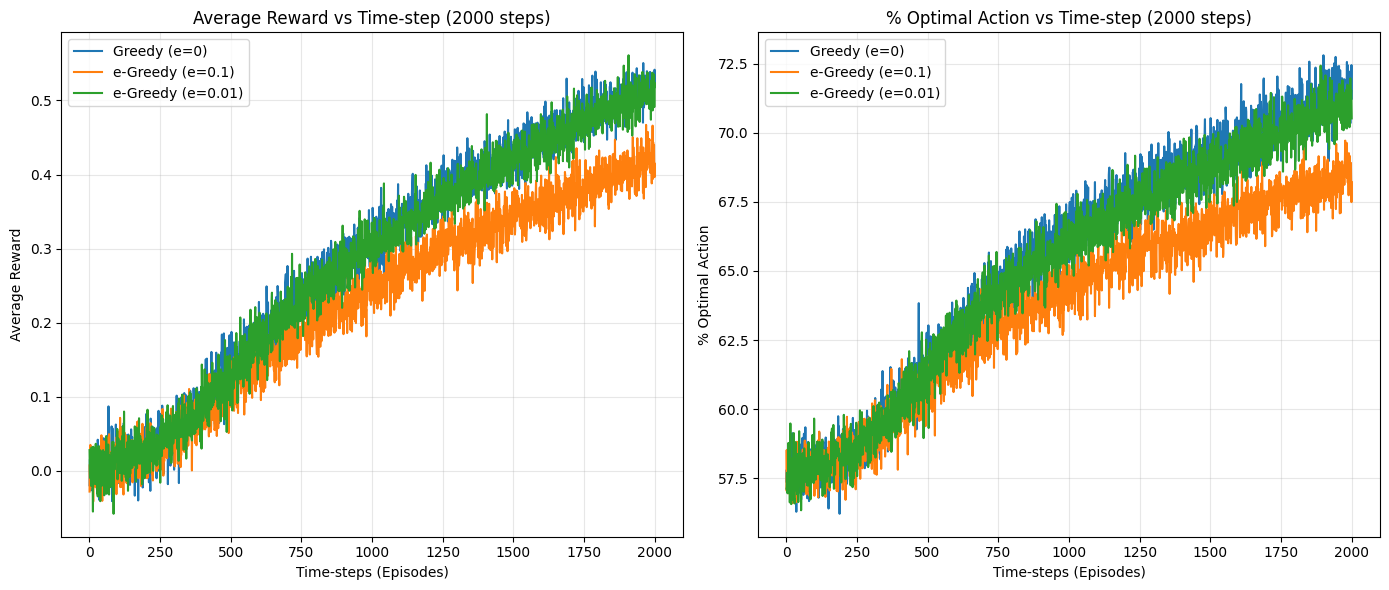

In [6]:
RUNS = 2000 
EPSILONS = [0, 0.1, 0.01]
STEPS_LIST = [2000]

for steps in STEPS_LIST:
    print(f"\nStarting Experiment: {steps} Time-steps")
    res_rew, res_opt = run_experiment(steps, RUNS, EPSILONS)
    plot_results(res_rew, res_opt, steps)


Starting Experiment: 2000 Time-steps
Running for epsilon=0 | Runs: 4000 | Steps: 2000


Eps 0: 100%|██████████| 4000/4000 [19:02<00:00,  3.50it/s]


Running for epsilon=0.1 | Runs: 4000 | Steps: 2000


Eps 0.1: 100%|██████████| 4000/4000 [19:07<00:00,  3.49it/s]


Running for epsilon=0.01 | Runs: 4000 | Steps: 2000


Eps 0.01: 100%|██████████| 4000/4000 [19:00<00:00,  3.51it/s]


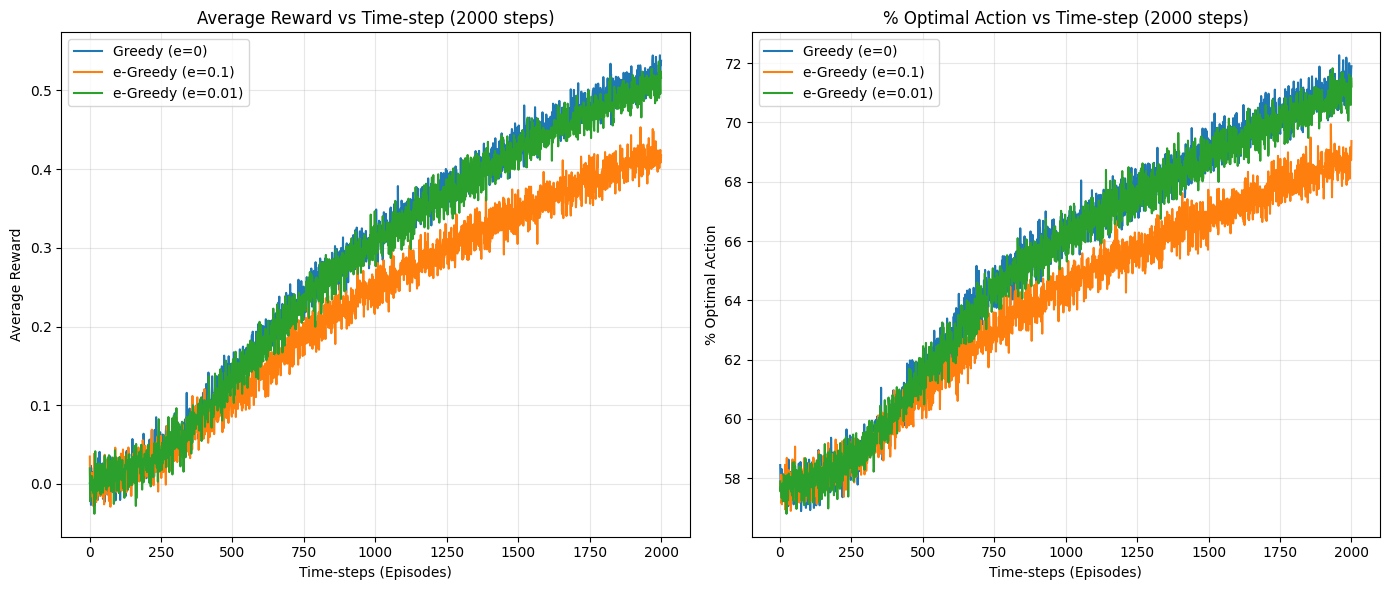

In [7]:
RUNS = 4000 
EPSILONS = [0, 0.1, 0.01]
STEPS_LIST = [2000]

for steps in STEPS_LIST:
    print(f"\nStarting Experiment: {steps} Time-steps")
    res_rew, res_opt = run_experiment(steps, RUNS, EPSILONS)
    plot_results(res_rew, res_opt, steps)